## Introduction

**Home Credit** [http://www.homecredit.net/about-us.aspx], a service dedicated to provided lines of credit (loans) to the unbanked population, hosted a competition on Kaggle to see what sort of models the machine learning community can develop to predict whether or not a client will repay a loan. 

The following files were provided:

* **application_train/application_test:** the main training and testing data with information about each loan application at Home Credit. Every loan has its own row and is identified by the feature `SK_ID_CURR`. The training application data comes with the `TARGET` indicating 0: the loan was repaid or 1: the loan was not repaid. 
* **bureau:** data concerning client's previous credits from other financial institutions. Each previous credit has its own row in bureau, but one loan in the application data can have multiple previous credits.
* **bureau_balance**: monthly data about the previous credits in bureau. Each row is one month of a previous credit, and a single previous credit can have multiple rows, one for each month of the credit length. 
* **previous_application:** previous applications for loans at Home Credit of clients who have loans in the application data. Each current loan in the application data can have multiple previous loans. Each previous application has one row and is identified by the feature `SK_ID_PREV`. 
* **pos_cash_balance:** monthly data about previous point of sale or cash loans clients have had with Home Credit. Each row is one month of a previous point of sale or cash loan, and a single previous loan can have many rows.
* **credit_card_balance:** monthly data about previous credit cards clients have had with Home Credit. Each row is one month of a credit card balance, and a single credit card can have many rows.
* **installments_payment:** payment history for previous loans at Home Credit. There is one row for every made payment and one row for every missed payment.

The following diagram shows the relationships among the different files:


![image](https://storage.googleapis.com/kaggle-media/competitions/home-credit/home_credit.png)



# Modelos 

* La entrada del proceso es el fichero "hcdr.csv" que es el resultado de aplicar todo el proceso EDA.

* Este workbook presenta la siguiente estructura coforme los pasos que realizamos:

    1. Importamos las librerías necesarias y cargamos los datos
    2. Obtenemos un array de características 'X_train'. 
        - Tomamos todas las variables menos el Target y el id: SK_ID_CURR
    3. Obtenemos un array con el target 'y_train'.
    4. Normalizamos los datos y rellenamos los datos vacios con su mediana
    5. Eliminamos variables altamente correlacionadas con otra variable
    6. Realizamos análisis de PCA y lo aplicamos
    7. Modelizamos:
        - 7.1 Dividimos los datos en conjunto de Train y de Test
        - 7.2 Creamos los modelos y evaluamos con Cross Validation
        - 7.3 Evaluamos los modelos incorporando una visión de negocio

## 1. Importamos las librerías y cargamos los datos

In [15]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 


# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# sklearn preprocessing to impute missings and scale features 
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# PCA
from sklearn.decomposition import PCA

#Gráfico de matriz de confusion
import itertools

# pivot table
from pandas import pivot_table 

### Importamos datos
Fuente del fichero: notebook **Home Credit Default Risk (HCDR) I**

In [16]:
app_train = pd.read_csv('hcdr.csv')

app_train.head(5)

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,WALLSMATERIAL_MODE_BLOCK,WALLSMATERIAL_MODE_MIXED,WALLSMATERIAL_MODE_MONOLITHIC,WALLSMATERIAL_MODE_OTHERS,WALLSMATERIAL_MODE_PANEL,WALLSMATERIAL_MODE_STONE_OR_BRICK,WALLSMATERIAL_MODE_WOODEN,EMERGENCYSTATE_MODE_NO,EMERGENCYSTATE_MODE_YES,TARGET
0,100002,0,0,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,...,False,False,False,False,False,True,False,True,False,1
1,100003,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,...,True,False,False,False,False,False,False,True,False,0
2,100004,1,1,1,0,67500.0,135000.0,6750.0,135000.0,0.010032,...,False,False,False,False,False,False,False,False,False,0
3,100006,0,0,1,0,135000.0,312682.5,29686.5,297000.0,0.008019,...,False,False,False,False,False,False,False,False,False,0
4,100007,0,0,1,0,121500.0,513000.0,21865.5,513000.0,0.028663,...,False,False,False,False,False,False,False,False,False,0


## 2. Obtenemos un array de características 'X_train' y otro con el Target 'y_train'

In [17]:
# Creamos el conjunto de datos de entrenamiento X_train eliminando las columnas TARGET (variable objetivo) 
# y SK_ID_CURR (identificador) del dataframe app_train
X_train = app_train.drop(columns = ['TARGET','SK_ID_CURR']) 


## 3. Obtenemos un array con el Target 'y_train'

In [18]:
# Creamos el array y_train con la variable objetivo (TARGET) del dataframe app_train
y_train = app_train['TARGET']

## 4. Normalizamos los datos e imputamos los datos nulos / ausentes con su mediana

In [19]:
X_train = X_train.astype('float32')


In [20]:
# Obtiene los nombres de las características/variables
features = list(X_train.columns)

# La elección entre media y mediana depende de la distribución de los datos:
# - Media: mejor para distribuciones normales/simétricas
# - Mediana: mejor para distribuciones sesgadas y datos con valores atípicos
# En este caso, como tenemos datos financieros que suelen tener valores atípicos,
# la mediana es una mejor opción ya que es más robusta a outliers

# Crea un imputador para reemplazar valores nulos con la mediana de cada columna
imputer = SimpleImputer(missing_values=np.nan, strategy='median')

# Ajusta el imputador con los datos de entrenamiento
imputer.fit(X_train)

# Transforma los datos reemplazando los valores nulos con la mediana
X_train = imputer.transform(X_train)

# Crea un escalador para normalizar los valores entre 0 y 1
scaler = MinMaxScaler(feature_range=(0, 1))

# Ajusta el escalador y transforma los datos para normalizarlos
scaler.fit(X_train)
X_train = scaler.transform(X_train)

In [21]:
# Muestro las dimensiones (número de filas y columnas) del conjunto de datos X_train
X_train.shape

(307511, 685)

## 5. Eliminamos variables altamente correlacionadas con otra variable

In [22]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

# -------------------- Lectura y preprocesado de datos --------------------
# Se lee el archivo CSV
app_train = pd.read_csv('hcdr.csv')

# Mostrar las primeras 5 filas (opcional)
print(app_train.head(5))

# Crear el conjunto de entrenamiento eliminando las columnas TARGET (objetivo) y SK_ID_CURR (identificador)
X_train = app_train.drop(columns=['TARGET','SK_ID_CURR'])
y_train = app_train['TARGET']

# Convertir X_train a float32
X_train = X_train.astype('float32')

# Guardar los nombres de las variables (columnas)
features = list(X_train.columns)

# Imputar valores nulos con la mediana de cada columna (dado que los datos financieros suelen tener outliers)
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
imputer.fit(X_train)
X_train = imputer.transform(X_train)

# Escalar los datos para normalizarlos en el rango [0,1]
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(X_train)
X_train = scaler.transform(X_train)

# Verificar las dimensiones de X_train (por ejemplo, (n_filas, n_columnas))
print("Dimensiones de X_train:", X_train.shape)

# -------------------- Parte 1: Eliminación de variables altamente correlacionadas --------------------
# Convertir X_train (que actualmente es un array de NumPy) a DataFrame y asignar los nombres originales de columnas
X_train = pd.DataFrame(X_train, columns=features)

# Calcular la matriz de correlación entre todas las variables
corr = X_train.corr()

# Crear un array booleano inicializado a True para marcar las columnas a mantener
columns_bool = np.full((corr.shape[0],), True, dtype=bool)

# Recorrer la matriz triangular superior de correlaciones para identificar variables altamente correlacionadas
for i in range(corr.shape[0]):
    for j in range(i + 1, corr.shape[0]):
        # Si se encuentra correlación mayor o igual a 0.8
        if corr.iloc[i, j] >= 0.8:
            # Marca la segunda variable para eliminarla (si aún no se ha marcado)
            if columns_bool[j]:
                columns_bool[j] = False

# Seleccionar las columnas a mantener (según la máscara booleana)
selected_columns = X_train.columns[columns_bool]

# Determinar las columnas eliminadas (aquellas no marcadas)
eliminated_columns = X_train.columns[~columns_bool]

# Actualizar X_train conservando solo las columnas seleccionadas
X_train = X_train[selected_columns]

# Mostrar las columnas que se mantuvieron y la cantidad
print("Columnas seleccionadas tras eliminar las variables altamente correlacionadas:")
print(selected_columns)
print(f"Número de columnas mantenidas: {len(selected_columns)}")

# ---------------------- Guardar en Excel los resultados ----------------------
# Crear un DataFrame para las variables mantenidas con una columna denominada "variables"
df_mantenidas = pd.DataFrame(selected_columns, columns=["variables"])

# Crear un DataFrame para las variables eliminadas con una columna denominada "variables"
df_eliminadas = pd.DataFrame(eliminated_columns, columns=["variables"])

# Exportar ambos DataFrames a archivos Excel sin incluir el índice
df_mantenidas.to_excel("variables_mantenidas.xlsx", index=False)
df_eliminadas.to_excel("variables_eliminadas.xlsx", index=False)

# -------------------- Parte 2: Seleccionar las 15 variables con mayor correlación con el target --------------------
# Asegurarse de que y_train esté definido, convirtiéndolo a Serie en caso de ser necesario
y_train = pd.Series(y_train)

# Calcular la correlación de cada variable (en X_train) con el target
cor_target = X_train.apply(lambda col: col.corr(y_train))

# Ordenar la correlación en valor absoluto de mayor a menor
cor_target_abs = cor_target.abs().sort_values(ascending=False)

# Seleccionar las 15 mejores variables según la correlación absoluta con el target
top_15 = cor_target_abs.head(15)

print("\nLas 15 variables con mayor correlación (valor absoluto) con el target:")
print(top_15)

# Mostrar también la correlación con signo (dirección de la correlación) para esas 15 variables
print("\nCorrelaciones (con signo) de las mejores 15 variables:")
print(cor_target[top_15.index])


   SK_ID_CURR  NAME_CONTRACT_TYPE  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0      100002                   0             0                1   
1      100003                   0             0                0   
2      100004                   1             1                1   
3      100006                   0             0                1   
4      100007                   0             0                1   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          202500.0    406597.5      24700.5         351000.0   
1             0          270000.0   1293502.5      35698.5        1129500.0   
2             0           67500.0    135000.0       6750.0         135000.0   
3             0          135000.0    312682.5      29686.5         297000.0   
4             0          121500.0    513000.0      21865.5         513000.0   

   REGION_POPULATION_RELATIVE  ...  WALLSMATERIAL_MODE_BLOCK  \
0                    0.018801  ...                  

## 6. PCA - Análisis de componentes principales

In [23]:
# PCA

# Importamos PCA de sklearn.decomposition
from sklearn.decomposition import PCA

# Creamos un objeto PCA sin especificar número de componentes y lo ajustamos a los datos, Al llamar a .fit(X_train), el modelo PCA se ajusta a los datos en X_train, y se calculan las componentes principales.
pca = PCA().fit(X_train)

# Calculamos la varianza acumulada sumando los ratios de varianza explicada para ver qué porcentaje de la variabilidad total de los datos es explicada por cada componente principal acumulativamente
varianza_acum = np.cumsum(pca.explained_variance_ratio_)

# Imprimimos los valores de varianza acumulada formateados a 4 decimales
print(['{:.4f}'.format(i) for i in varianza_acum])


['0.0637', '0.1111', '0.1562', '0.1972', '0.2350', '0.2696', '0.2997', '0.3266', '0.3517', '0.3759', '0.3979', '0.4194', '0.4404', '0.4606', '0.4802', '0.4972', '0.5138', '0.5302', '0.5460', '0.5616', '0.5771', '0.5919', '0.6054', '0.6185', '0.6310', '0.6429', '0.6542', '0.6652', '0.6758', '0.6861', '0.6960', '0.7058', '0.7145', '0.7231', '0.7310', '0.7385', '0.7455', '0.7525', '0.7592', '0.7654', '0.7711', '0.7767', '0.7821', '0.7874', '0.7926', '0.7977', '0.8027', '0.8076', '0.8124', '0.8173', '0.8220', '0.8266', '0.8312', '0.8357', '0.8401', '0.8443', '0.8485', '0.8524', '0.8562', '0.8600', '0.8636', '0.8670', '0.8703', '0.8735', '0.8766', '0.8796', '0.8826', '0.8856', '0.8884', '0.8912', '0.8937', '0.8961', '0.8984', '0.9008', '0.9030', '0.9052', '0.9073', '0.9094', '0.9114', '0.9134', '0.9154', '0.9172', '0.9190', '0.9207', '0.9224', '0.9241', '0.9258', '0.9275', '0.9291', '0.9307', '0.9322', '0.9336', '0.9351', '0.9365', '0.9378', '0.9392', '0.9405', '0.9417', '0.9429', '0.9441',

Diagrama de codo

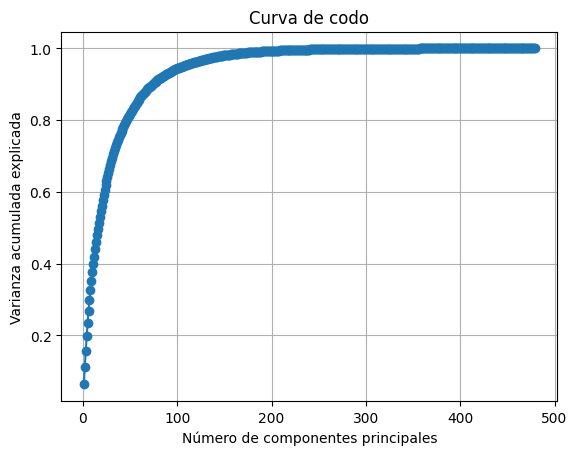

In [24]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(varianza_acum) + 1), varianza_acum, marker='o')
plt.xlabel('Número de componentes principales')
plt.ylabel('Varianza acumulada explicada')
plt.title('Curva de codo')
plt.grid()
plt.show()

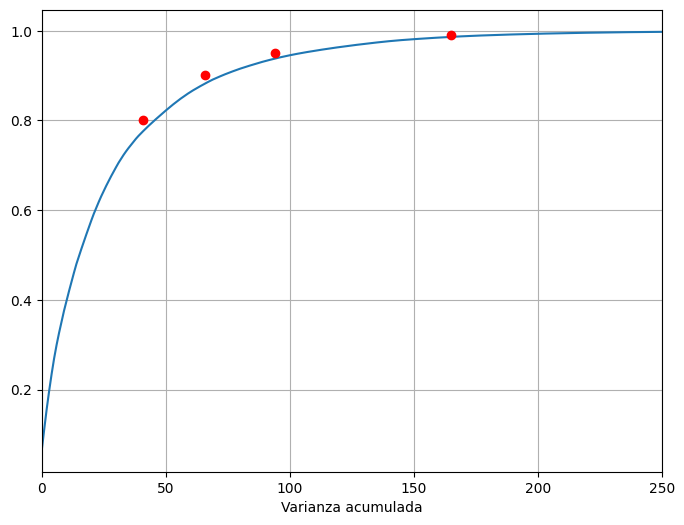

In [25]:
#dibujamos el PCA obtenido 

fig, eje = plt.subplots(figsize=(8,6))
eje.plot(varianza_acum)
eje.set_xlabel('Nº componentes')
eje.set_xlabel('Varianza acumulada')

eje.grid()
eje.plot(41,0.8010, 'ro') # componente i + 1
eje.plot(66,0.9011, 'ro') # componente i + 1
eje.plot(94,0.9500, 'ro') # componente i + 1
eje.plot(165,0.990, 'ro') # componente i + 1
plt.xlim(0,250)
plt.show()


In [26]:
# Seleccionamos 166 componentes para recoger > 99% de la varianza explicada
# Creamos un objeto PCA especificando que queremos 166 componentes principales
pca = PCA(n_components = 166)

# Aplicamos la transformación PCA a los datos de entrenamiento:
# - fit: Calcula la matriz de covarianza y los componentes principales
# - transform: Proyecta los datos originales en el nuevo espacio de componentes principales
X_train = pca.fit_transform(X_train)

# Mostramos la forma (dimensiones) del conjunto de datos transformado
X_train.shape


(307511, 166)

### **BUSQUEDA VARIABLES IMPORTANTES**

Las 20 variables con mayor importancia:
                                    variable  importance
74                            EXT_SOURCE_AVG    0.019939
29                              EXT_SOURCE_2    0.016404
30                              EXT_SOURCE_3    0.016261
9                                 DAYS_BIRTH    0.007886
10                             DAYS_EMPLOYED    0.007233
12                           DAYS_ID_PUBLISH    0.007121
73                     DAYS_EMPLOYED_PERCENT    0.006936
11                         DAYS_REGISTRATION    0.006626
72                               CREDIT_TERM    0.006517
71                    ANNUITY_INCOME_PERCENT    0.006380
321   PREVIOUS_DAYS_LAST_DUE_1ST_VERSION_MAX    0.006161
70                      CREDIT_GOODS_PERCENT    0.006141
69                     CREDIT_INCOME_PERCENT    0.006009
6                                AMT_ANNUITY    0.005684
320  PREVIOUS_DAYS_LAST_DUE_1ST_VERSION_MEAN    0.005666
79                         INSTALMENT_INDEX_    

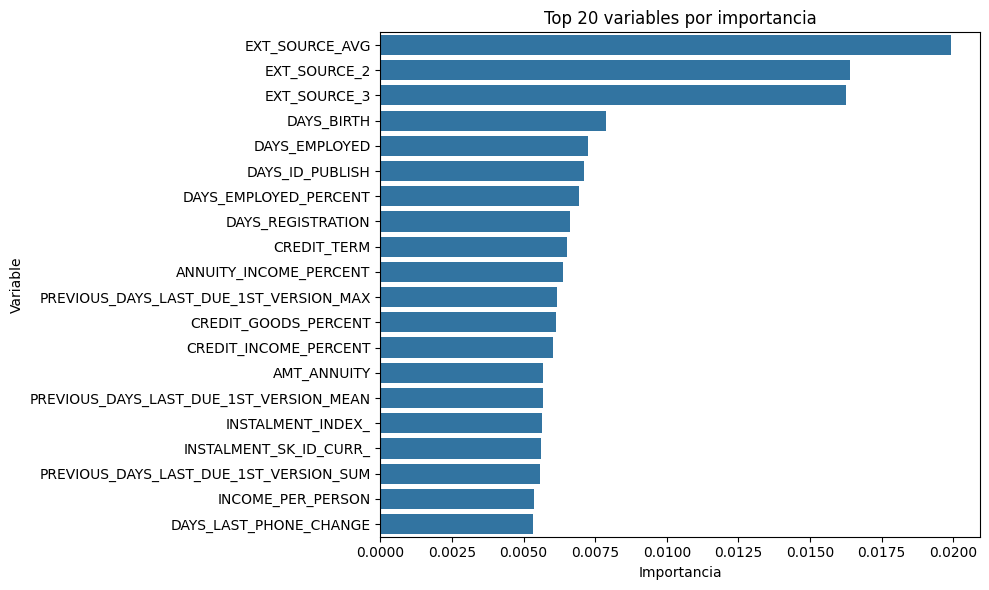

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier  
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# --------------------------- CARGA Y PREPROCESAMIENTO ---------------------------

# Cargar los datos (asegúrate de tener el CSV en la ruta correcta)
app_train = pd.read_csv('hcdr.csv')

# Eliminar columnas que no se usan para las predicciones (identificador y variable objetivo)
X = app_train.drop(columns=['TARGET', 'SK_ID_CURR'])
y = app_train['TARGET']

# Si hay valores nulos, se imputan con la mediana (estrategia robusta para datos con outliers)
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# Escalar los datos 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Para conservar los nombres originales de las variables
features = X.columns

# Dividir en entrenamiento y prueba (por ejemplo, 70% entrenamiento, 30% prueba)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# --------------------------- ENTRENAMIENTO DEL MODELO ---------------------------

# Definir y entrenar el clasificador RandomForest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# --------------------------- EXTRAER IMPORTANCIA DE VARIABLES ---------------------------

# Obtener la importancia de cada variable del modelo
importances = rf_model.feature_importances_

# Crear un DataFrame con las variables y su importancia
df_importance = pd.DataFrame({
    'variable': features,
    'importance': importances
})

# Ordenar de mayor a menor importancia
df_importance = df_importance.sort_values(by='importance', ascending=False)

# Mostrar las 20 variables más importantes
print("Las 20 variables con mayor importancia:")
print(df_importance.head(20))

# --------------------------- PLOTEAR LAS IMPORTANCIAS ---------------------------

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='variable', data=df_importance.head(20))
plt.title("Top 20 variables por importancia")
plt.xlabel("Importancia")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()


## 7. Modelización

### 7.1 Dividimos los datos en entramiento 80% y test 20%

In [27]:
from sklearn.model_selection import train_test_split

M_X_train, X_test, M_y_train, y_test = train_test_split(X_train, y_train, test_size=0.2)

### 7.2 Creamos los modelos y evaluamos con Cross Validation

In [ ]:
# model

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import lightgbm as lgbm
from lightgbm import LGBMClassifier

import time

# Using Cross Validation to find a good model
num_folds = 5
seed = 0
models = []

# Models

models.append(('RF_bal', RandomForestClassifier(random_state=0, n_estimators = 100, criterion = 'entropy')))  

models.append(('LGBM_weight', LGBMClassifier(objective = 'binary', scale_pos_weight = 0.5,
                learning_rate = 0.05, 
                reg_alpha = 0.1, reg_lambda = 0.1, 
                n_jobs = -1, random_state = 50, boosting = 'gbdt', n_estimators = 500)))

models.append(('LGBM_gbdt', LGBMClassifier(objective = 'binary', bagging_fraction = 0.8, boosting = 'gbdt', n_estimators = 150, num_leaves = 25, max_depth = 35, min_data_in_leaf = 100)))

models.append(('LR', LogisticRegression(solver = 'newton-cg', random_state=1)))

models.append(('MLP128log', MLPClassifier(hidden_layer_sizes=(128,), random_state=1, activation='logistic', solver='lbfgs')))
models.append(('MLP128tanh', MLPClassifier(hidden_layer_sizes=(128,), random_state=1, activation='tanh', solver='sgd')))

# Corregido: Reemplazado min_impurity_split por min_impurity_decrease
models.append(('DTC25_125E', DecisionTreeClassifier(criterion = 'gini', min_impurity_decrease = 1e-05, random_state=0, min_samples_split=10, max_depth = 25, max_leaf_nodes = 125)))

models.append(('GNB', GaussianNB()))

# iterate over models and print cross val scores
results = []
names = []

print('Please wait while models train..')
for name, model in models:

  # start timer
  start = time.time()

  print ('EVALUANDO: {clas}'.format(clas=name))

  with warnings.catch_warnings():
    warnings.filterwarnings("ignore")

    # Cross Validation y distintos evaluadores
    # Modificado: Añadido shuffle=True para poder usar random_state
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
    
    cv_results = cross_val_score(model, M_X_train, M_y_train, cv=kfold, scoring='roc_auc')
    
    predicciones = cross_val_predict(model, M_X_train, M_y_train, cv=kfold)
    
    # evaluadores
    reporte = (classification_report(M_y_train, predicciones,digits=4))
    
    print('{}  :  {}'.format('roc_auc',cv_results.mean()))
    print()      
    print(reporte)
    
    
    matriz_conf = confusion_matrix(M_y_train, predicciones)
    print()
    print(matriz_conf)
        
  names.append(name)
  results.append(cv_results)
    
  end = time.time()
  time_run = (end - start)/60

  print('{time} minutos'.format(time = time_run))
  print()
  print()
  print()



### 7.3 Evaluamos los modelos incorporando una visión de negocio



Función para matriz (confusión y de ganancias)

In [32]:
def plot_confusion_matrix(cm, classes, title, cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j]), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    

Evaluamos los modelos

In [ ]:
# model

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import lightgbm as lgbm
from lightgbm import LGBMClassifier

import time

num_folds = 5
seed = 0
evaluacion = list()
  
for name, model in models:

    # start timer
    start = time.time()

    print ('EVALUANDO: {clas}'.format(clas=name))

    with warnings.catch_warnings():
      warnings.filterwarnings("ignore")

      # Cross Validation y distintos evaluadores
      kfold = KFold(n_splits=num_folds, random_state=seed)

      # predicciones sobre el fichero completo
      model.fit(X_train, y_train)
      predicciones = model.predict(X_train)
      
    # pintamos matriz de ganancias / pérdidas

    classes=['Sí paga', 'No paga']
    fig, ax = plt.subplots(figsize=(12,8))
    plt.subplot(2,2,1)

    #ganancia de cada posibilidad de estimaciones
    tab_pred = pd.DataFrame(predicciones)
    join = tab_pred.merge(app_train, left_index=True, right_index=True)
    join = join.rename(index=str, columns={0: "PREDICCION"})
    join = join[['AMT_CREDIT','TARGET','PREDICCION']]
    
    from pandas import pivot_table 
    agg_credit = join.groupby(['TARGET', 'PREDICCION'])['AMT_CREDIT'].agg(['sum', 'count'])

    agg_sum = np.round(pivot_table(agg_credit, values='sum', index=['TARGET'], columns=['PREDICCION'], aggfunc=np.sum)/1e+06,0)
    agg_count = pivot_table(agg_credit, values='count', index=['TARGET'], columns=['PREDICCION'], aggfunc=np.sum)

    np.set_printoptions(formatter={'float_kind':'{:f}'.format})
    agg_sum = agg_sum.values
    agg_count = agg_count.values

    plot_confusion_matrix(agg_count, classes=classes, title='Matriz de confusion - train total')
    plt.tight_layout()
    plt.show()

    plot_confusion_matrix(agg_sum, classes=classes, title='Matriz de ganancias / pérdidas')
    plt.tight_layout()
    plt.show()

      # stop timing
      
    end = time.time()
    time_run = (end - start)/60
    print('{time} minutos'.format(time = time_run))

